# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
from math import sqrt

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as sct
import statsmodels.stats as st
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from loguru import logger

In [2]:
# Algumas configurações para o matplotlib.
"""%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()"""

'%matplotlib inline\n\nfrom IPython.core.pylabtools import figsize\n\n\nfigsize(12, 8)\n\nsns.set()'

In [3]:
fifa = pd.read_csv("./fifa2019.csv")

In [4]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Quick review on dataset proprieties
Steps:
* data describe
* Missing data 
* Standardization

In [5]:
fifa.head()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [6]:
fifa.describe()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,25.122206,66.238699,71.307299,49.734181,45.550911,52.298144,58.686712,42.909026,55.371001,47.170824,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,4.669943,6.908930,6.136496,18.364524,19.525820,17.379909,14.699495,17.694408,18.910371,18.395264,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,46.000000,48.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,62.000000,67.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,66.000000,71.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,28.000000,71.000000,75.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,45.000000,94.000000,95.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


In [7]:
missing = pd.DataFrame({'columns': fifa.columns,
                        'missing': fifa.isna().sum(),
                        'missing %': (fifa.isna().sum() / fifa.shape[1]),
                        'unique': fifa.nunique()})
missing

,columns,missing,missing %,unique
Age,Age,0,0.000000,29
Overall,Overall,0,0.000000,48
Potential,Potential,0,0.000000,47
Crossing,Crossing,48,1.297297,89
Finishing,Finishing,48,1.297297,93
HeadingAccuracy,HeadingAccuracy,48,1.297297,91
ShortPassing,ShortPassing,48,1.297297,85
Volleys,Volleys,48,1.297297,87
Dribbling,Dribbling,48,1.297297,94
Curve,Curve,48,1.297297,89


In [8]:
# Drop nan rows
fifa = fifa.dropna()

## Inicia sua análise a partir daqui

In [9]:
# Sua análise começa aqui.


## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [23]:
# Fitting data
pca = PCA(n_components=(fifa.shape[1] -1))
pca_fit = pca.fit_transform(fifa)
variance_ratio = pca.explained_variance_ratio_

Text(0.5, 1.0, '2 Principal Components')

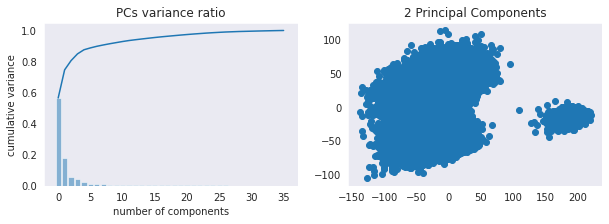

In [62]:
# Visualizing variance ratio in PCA
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
sns.set_style('dark')
ax[0].plot(np.cumsum(variance_ratio))
ax[0].bar(range(fifa.shape[1]-1), variance_ratio, alpha=0.5, align='center')
ax[0].set_xlabel('number of components')
ax[0].set_ylabel('cumulative variance')
ax[0].set_title('PCs variance ratio')

# Plot 2 PCs
fifa_pca = pd.DataFrame(pca_fit)
ax[1].scatter(pca_fit[:,0], pca_fit[:,1])
ax[1].set_title('2 Principal Components')

In [11]:
def q1():
    # Retorne aqui o resultado da questão 1.
    return np.round(variance_ratio[0], 3 )
q1()

0.565

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [12]:
def q2():
    # Retorne aqui o resultado da questão 2.
    return len(variance_ratio[np.cumsum(variance_ratio) < 0.951])
q2()

15

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [13]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [14]:
def q3():
    # Retorne aqui o resultado da questão 3.
    pca_2cp = PCA(n_components=2)
    pca_2cp.fit(fifa)
    return tuple(np.dot(pca_2cp.components_, x).round(3))
q3()

(186.556, -6.592)

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [15]:
def q4():
    # Retorne aqui o resultado da questão 4.
    features, target = fifa.drop('Overall', axis='columns'), fifa['Overall']
    linear_regression = LinearRegression()

    rfe = RFE(linear_regression, n_features_to_select=5)
    rfe.fit(features, target)
    
    return features.columns[rfe.support_].tolist()
q4()

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']